In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥ 1.0.1 is required
from packaging import version
import sklearn
print(sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt

1.4.1.post1


In [2]:
# weather data
weather = pd.read_csv('data/weather.csv')
weather.head()

,FID,the_geom,code,timestamp,precip_quantity,precip_range,temp,temp_min,temp_max,temp_grass_min,...,wind_speed_unit,wind_direction,wind_peak_speed,humidity_relative,weather_current,pressure,pressure_station_level,sun_duration_24hours,short_wave_from_sky_24hours,cloudiness
0,synop_data.6407.2023-02-28 23:00:00+00,POINT (51.200341 2.887306),6407,2023-02-28T23:00:00,NaN,NaN,-0.3,NaN,NaN,NaN,...,1,50.0,4.0,NaN,NaN,1031.8,1031.2,NaN,NaN,1.0
1,synop_data.6418.2023-02-28 23:00:00+00,POINT (51.347375 3.201846),6418,2023-02-28T23:00:00,NaN,NaN,4.6,NaN,NaN,NaN,...,1,37.9,6.8,61.8,NaN,1031.9,1030.2,NaN,NaN,0.0
2,synop_data.6414.2023-02-28 23:00:00+00,POINT (50.90398 3.121692),6414,2023-02-28T23:00:00,NaN,NaN,-0.3,NaN,NaN,NaN,...,1,19.2,2.7,72.5,NaN,1031.9,1028.5,NaN,NaN,NaN
3,synop_data.6434.2023-02-28 23:00:00+00,POINT (50.980293 3.816003),6434,2023-02-28T23:00:00,NaN,NaN,-2.6,NaN,NaN,NaN,...,1,23.6,3.1,78.4,NaN,1031.5,1029.3,NaN,NaN,NaN
4,synop_data.6434.2023-03-01 00:00:00+00,POINT (50.980293 3.816003),6434,2023-03-01T00:00:00,0.0,1.0,-0.5,NaN,NaN,NaN,...,1,27.9,3.8,72.8,NaN,1031.7,1029.6,401.0,10335800.0,NaN


In [3]:
# solar data
solar = pd.read_csv('data/solar.csv')
solar.head()

,timestamp,kwh
0,2023-03-11 16:00:10.160454+01,0.54
1,2023-03-11 17:00:10.217795+01,1.02
2,2023-03-11 18:00:10.284064+01,1.17
3,2023-03-11 19:00:10.224836+01,1.18
4,2023-03-11 20:00:10.201847+01,1.18


In [4]:
solar["kwh_diff"] = solar["kwh"] - solar["kwh"].shift(1, fill_value=0)
solar.head()

,timestamp,kwh,kwh_diff
0,2023-03-11 16:00:10.160454+01,0.54,0.54
1,2023-03-11 17:00:10.217795+01,1.02,0.48
2,2023-03-11 18:00:10.284064+01,1.17,0.15
3,2023-03-11 19:00:10.224836+01,1.18,0.01
4,2023-03-11 20:00:10.201847+01,1.18,0.00


In [5]:
solar.describe()

,kwh,kwh_diff
count,7907.000000,7907.000000
mean,1222.790435,0.258381
std,707.659230,19.545509
min,0.000000,-1185.158200
25%,547.675800,0.000000
50%,1444.772000,0.000000
75%,1897.269400,0.238600
max,2043.015400,1269.965600


In [7]:
# sunrise-sunset data
sun = pd.read_excel('data/sunrise-sunset.xlsx')
sun.head()

,datum,Opkomst,Op ware middag,Ondergang
0,2023-01-01,08:45:00,12:46:00,16:47:00
1,2023-01-02,08:45:00,12:46:00,16:48:00
2,2023-01-03,08:45:00,12:47:00,16:49:00
3,2023-01-04,08:44:00,12:47:00,16:51:00
4,2023-01-05,08:44:00,12:48:00,16:52:00


In [8]:
# clean weather timestamp data
weather["timestamp"] = weather["timestamp"].apply(lambda date: pd.to_datetime(date).strftime("%Y-%m-%d %H"))
weather.head()

,FID,the_geom,code,timestamp,precip_quantity,precip_range,temp,temp_min,temp_max,temp_grass_min,...,wind_speed_unit,wind_direction,wind_peak_speed,humidity_relative,weather_current,pressure,pressure_station_level,sun_duration_24hours,short_wave_from_sky_24hours,cloudiness
0,synop_data.6407.2023-02-28 23:00:00+00,POINT (51.200341 2.887306),6407,2023-02-28 23,NaN,NaN,-0.3,NaN,NaN,NaN,...,1,50.0,4.0,NaN,NaN,1031.8,1031.2,NaN,NaN,1.0
1,synop_data.6418.2023-02-28 23:00:00+00,POINT (51.347375 3.201846),6418,2023-02-28 23,NaN,NaN,4.6,NaN,NaN,NaN,...,1,37.9,6.8,61.8,NaN,1031.9,1030.2,NaN,NaN,0.0
2,synop_data.6414.2023-02-28 23:00:00+00,POINT (50.90398 3.121692),6414,2023-02-28 23,NaN,NaN,-0.3,NaN,NaN,NaN,...,1,19.2,2.7,72.5,NaN,1031.9,1028.5,NaN,NaN,NaN
3,synop_data.6434.2023-02-28 23:00:00+00,POINT (50.980293 3.816003),6434,2023-02-28 23,NaN,NaN,-2.6,NaN,NaN,NaN,...,1,23.6,3.1,78.4,NaN,1031.5,1029.3,NaN,NaN,NaN
4,synop_data.6434.2023-03-01 00:00:00+00,POINT (50.980293 3.816003),6434,2023-03-01 00,0.0,1.0,-0.5,NaN,NaN,NaN,...,1,27.9,3.8,72.8,NaN,1031.7,1029.6,401.0,10335800.0,NaN


In [9]:
# clean solar timestamp data
solar["timestamp"] = solar["timestamp"].apply(lambda x: pd.to_datetime(x).strftime("%Y-%m-%d %H"))
solar.head()

,timestamp,kwh,kwh_diff
0,2023-03-11 16,0.54,0.54
1,2023-03-11 17,1.02,0.48
2,2023-03-11 18,1.17,0.15
3,2023-03-11 19,1.18,0.01
4,2023-03-11 20,1.18,0.00


In [11]:
data = weather.merge(solar, on="timestamp", how="inner")
print(data.shape)
data.head()

(31628, 23)


,FID,the_geom,code,timestamp,precip_quantity,precip_range,temp,temp_min,temp_max,temp_grass_min,...,wind_peak_speed,humidity_relative,weather_current,pressure,pressure_station_level,sun_duration_24hours,short_wave_from_sky_24hours,cloudiness,kwh,kwh_diff
0,synop_data.6434.2023-03-11 16:00:00+00,POINT (50.980293 3.816003),6434,2023-03-11 16,NaN,NaN,6.8,NaN,NaN,NaN,...,3.0,54.4,NaN,1011.9,1009.9,NaN,NaN,NaN,0.54,0.54
1,synop_data.6414.2023-03-11 16:00:00+00,POINT (50.90398 3.121692),6414,2023-03-11 16,NaN,NaN,7.0,NaN,NaN,NaN,...,3.8,53.0,NaN,1011.5,1008.3,NaN,NaN,NaN,0.54,0.54
2,synop_data.6418.2023-03-11 16:00:00+00,POINT (51.347375 3.201846),6418,2023-03-11 16,NaN,NaN,5.6,NaN,NaN,NaN,...,3.9,66.0,NaN,1011.6,1009.9,NaN,NaN,NaN,0.54,0.54
3,synop_data.6407.2023-03-11 16:00:00+00,POINT (51.200341 2.887306),6407,2023-03-11 16,NaN,NaN,5.8,NaN,NaN,NaN,...,4.0,NaN,NaN,1011.5,1010.9,NaN,NaN,7.0,0.54,0.54
4,synop_data.6414.2023-03-11 17:00:00+00,POINT (50.90398 3.121692),6414,2023-03-11 17,NaN,NaN,6.7,NaN,NaN,NaN,...,4.8,55.0,NaN,1011.3,1008.0,NaN,NaN,NaN,1.02,0.48


In [33]:
data.tail()

,FID,the_geom,code,timestamp,precip_quantity,precip_range,temp,temp_min,temp_max,temp_grass_min,...,wind_direction,wind_peak_speed,humidity_relative,weather_current,pressure,pressure_station_level,sun_duration_24hours,short_wave_from_sky_24hours,cloudiness,kwh
31623,synop_data.6418.2024-02-04 10:00:00+00,POINT (51.347375 3.201846),6418,2024-02-04 10,NaN,NaN,9.8,NaN,NaN,NaN,...,236.8,13.8,93.6,NaN,1024.9,1023.2,NaN,NaN,8.0,2042.7763
31624,synop_data.6414.2024-02-04 11:00:00+00,POINT (50.90398 3.121692),6414,2024-02-04 11,NaN,NaN,11.2,NaN,NaN,NaN,...,253.9,11.5,90.4,NaN,1026.5,1023.3,NaN,NaN,NaN,2043.0154
31625,synop_data.6418.2024-02-04 11:00:00+00,POINT (51.347375 3.201846),6418,2024-02-04 11,NaN,NaN,9.8,NaN,NaN,NaN,...,234.8,14.1,92.9,NaN,1025.1,1023.4,NaN,NaN,7.0,2043.0154
31626,synop_data.6434.2024-02-04 11:00:00+00,POINT (50.980293 3.816003),6434,2024-02-04 11,NaN,NaN,11.4,NaN,NaN,NaN,...,257.0,11.3,87.5,NaN,1026.1,1024.0,NaN,NaN,NaN,2043.0154
31627,synop_data.6407.2024-02-04 11:00:00+00,POINT (51.200341 2.887306),6407,2024-02-04 11,NaN,NaN,11.4,NaN,NaN,NaN,...,240.0,15.0,NaN,NaN,1025.7,1025.1,NaN,NaN,7.0,2043.0154


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31628 entries, 0 to 31627
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   FID                          31628 non-null  object 
 1   the_geom                     31628 non-null  object 
 2   code                         31628 non-null  int64  
 3   timestamp                    31628 non-null  object 
 4   precip_quantity              4906 non-null   float64
 5   precip_range                 5008 non-null   float64
 6   temp                         31628 non-null  float64
 7   temp_min                     1252 non-null   float64
 8   temp_max                     1253 non-null   float64
 9   temp_grass_min               936 non-null    float64
 10  wind_speed                   31615 non-null  float64
 11  wind_speed_unit              31628 non-null  int64  
 12  wind_direction               31248 non-null  float64
 13  wind_peak_speed 

In [42]:
data.describe()

,code,precip_quantity,precip_range,temp,temp_min,temp_max,temp_grass_min,wind_speed,wind_speed_unit,wind_direction,wind_peak_speed,humidity_relative,weather_current,pressure,pressure_station_level,sun_duration_24hours,short_wave_from_sky_24hours,cloudiness,kwh
count,31628.000000,4906.000000,5008.000000,31628.000000,1252.000000,1253.000000,936.000000,31615.000000,31628.0,31248.000000,31607.000000,23721.000000,1988.000000,31616.000000,31628.000000,948.000000,6.320000e+02,11757.000000,31628.000000
mean,6418.250000,0.902711,1.498802,12.573144,9.490655,15.742458,6.959188,4.966154,1.0,188.845244,8.577166,80.889065,36.891851,1013.895047,1012.052058,349.724684,1.131930e+07,5.355703,1222.790435
std,9.909117,2.510817,0.500048,6.083900,5.137094,6.914885,5.321523,2.807257,0.0,93.255603,4.286957,14.216291,26.552052,11.448705,11.459136,288.303671,8.502365e+06,2.539321,707.625667
min,6407.000000,0.000000,1.000000,-5.900000,-6.000000,-1.000000,-10.200000,0.000000,1.0,0.100000,0.300000,24.700000,1.000000,965.100000,963.500000,0.000000,4.169000e+05,0.000000,0.000000
25%,6412.250000,0.000000,1.000000,8.600000,6.575000,10.800000,4.000000,2.953000,1.0,121.100000,5.300000,72.400000,11.000000,1008.100000,1006.200000,77.750000,3.754300e+06,3.000000,547.675800
50%,6416.000000,0.000000,1.000000,12.100000,9.700000,14.800000,7.300000,4.497000,1.0,208.900000,8.000000,84.300000,25.000000,1015.800000,1013.900000,310.000000,9.520900e+06,7.000000,1444.772000
75%,6422.000000,0.400000,2.000000,16.900000,13.300000,21.200000,10.850000,6.635500,1.0,252.400000,11.400000,91.900000,60.000000,1021.700000,1019.900000,588.000000,1.819400e+07,7.000000,1897.269400
max,6434.000000,43.400000,2.000000,32.400000,23.000000,32.900000,20.500000,21.088000,1.0,360.000000,31.100000,100.000000,100.000000,1041.800000,1040.400000,950.000000,2.943290e+07,8.000000,2043.015400


In [43]:
data["the_geom"].value_counts()

POINT (50.980293 3.816003)    7907
POINT (50.90398 3.121692)     7907
POINT (51.347375 3.201846)    7907
POINT (51.200341 2.887306)    7907
Name: the_geom, dtype: int64

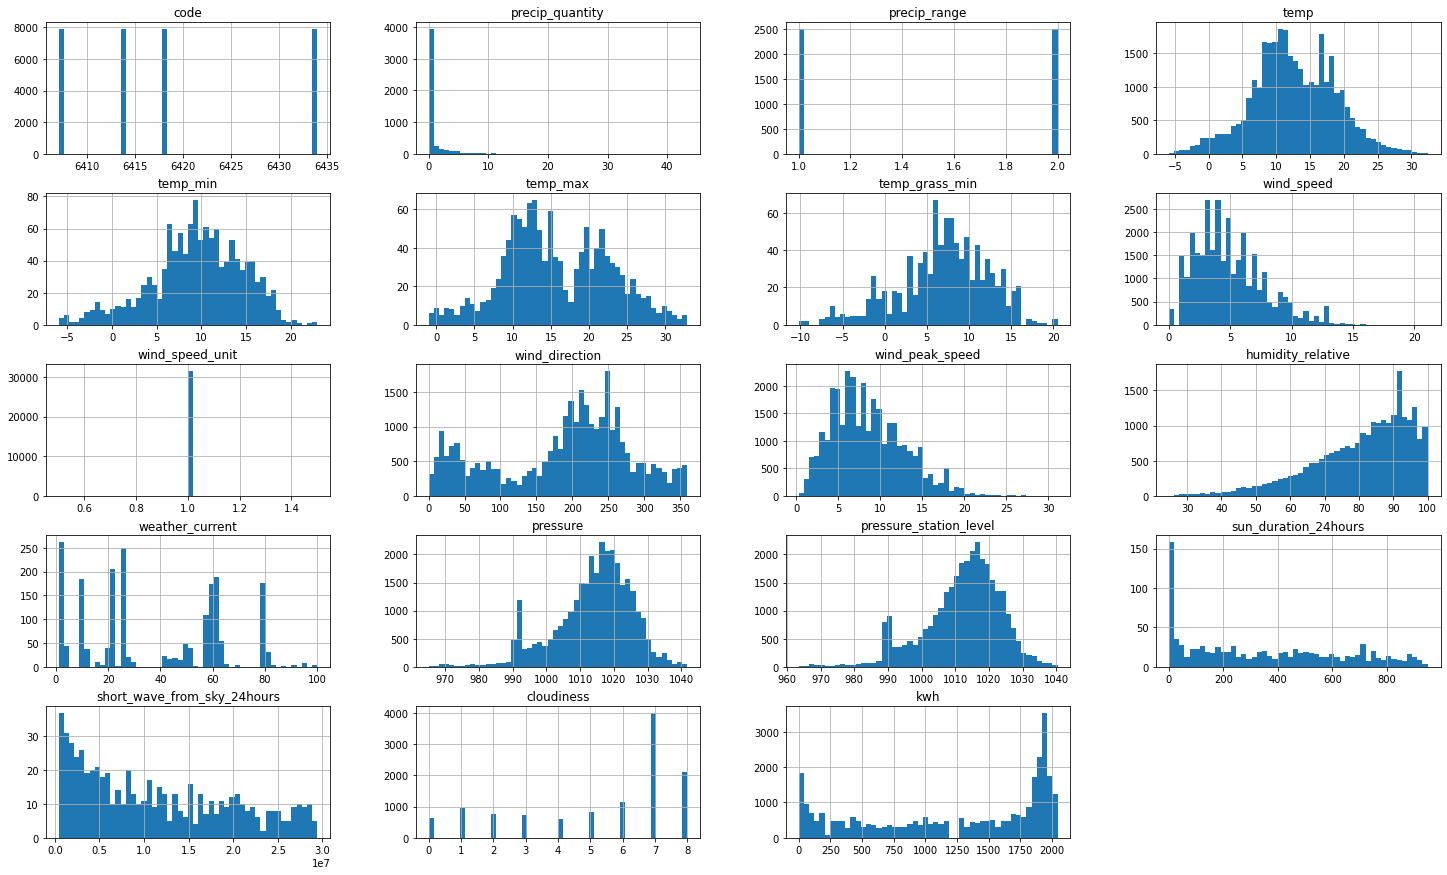

In [38]:
data.hist(bins=50, figsize=(25, 15))
plt.show()

Observations:
1. wind_speed_unit has only one value
2. precip_ranges only two values
3. the_geom and code stand for the same thing
4. humidity_relative looks capped at 100
5. kwh is cummulative

In [47]:
import numpy as np
np.random.seed(42)

In [51]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)
len(train_set), len(test_set) 

(25302, 6326)

In [45]:
corr_matrix = data.corr(numeric_only=True)
corr_matrix["kwh"].sort_values(ascending=False).round(2)

kwh                            1.00
humidity_relative              0.15
wind_direction                 0.09
precip_quantity                0.09
cloudiness                     0.04
weather_current                0.02
pressure_station_level         0.00
pressure                       0.00
precip_range                   0.00
code                          -0.00
wind_peak_speed               -0.03
wind_speed                    -0.03
temp_grass_min                -0.07
temp_min                      -0.09
temp                          -0.17
temp_max                      -0.19
sun_duration_24hours          -0.34
short_wave_from_sky_24hours   -0.54
wind_speed_unit                 NaN
Name: kwh, dtype: float64

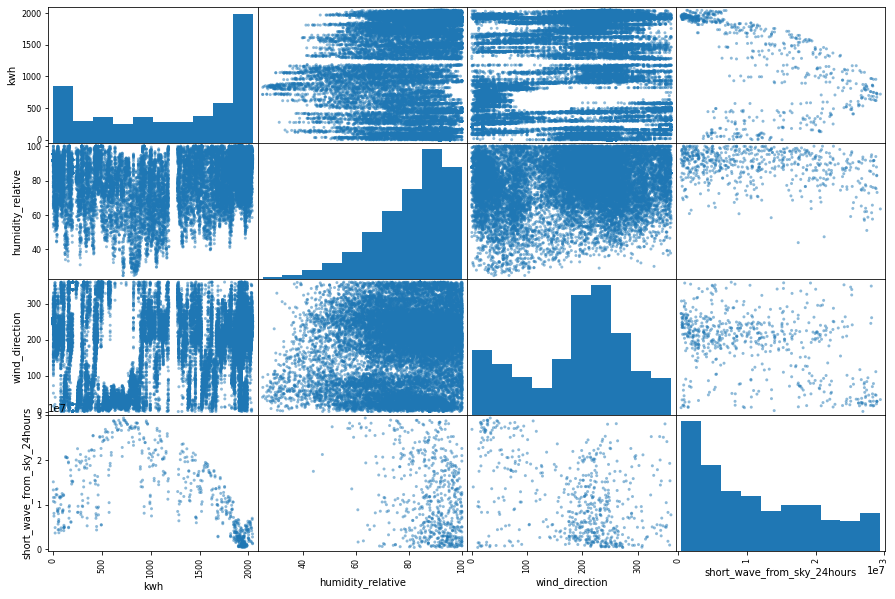

In [40]:
from pandas.plotting import scatter_matrix

attributes = ["kwh", "humidity_relative", "wind_direction", "short_wave_from_sky_24hours"]
scatter_matrix(data[attributes], figsize=(15, 10))
plt.show()